# Hyper Parameter Optimization for Elastic Net

In [7]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/ElasticNet'

In [9]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [10]:
from sklearn.base import clone
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline  

## Load Data

In [11]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [12]:
# using grid search to find the best hyperparameters for the dft model
print("['DFT ElasticNet'] HP optimazation begin...")
# create a pipeline with standard scaler and ElasticNet
en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=5000, random_state=RANDOM_SEED))
])
# define the parameter grid for ElasticNet
param_grid = {
    'en__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'en__l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=en_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

['DFT ElasticNet'] HP optimazation begin...
Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('en',
                                        ElasticNet(max_iter=5000,
                                                   random_state=42))]),
             n_jobs=-1,
             param_grid={'en__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'en__l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [13]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_en__alpha', 
                                 'param_en__l1_ratio', 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'en__alpha': 0.01, 'en__l1_ratio': 0.05}
Best Cross-Validation RMSE: 1.1299


,rank_test_score,param_en__alpha,param_en__l1_ratio,train_rmse,test_rmse
0,1,0.01,0.05,1.127745,1.129882
1,2,0.01,0.10,1.128436,1.130501
2,3,0.01,0.30,1.131908,1.133775
3,4,0.01,0.50,1.135404,1.137127
7,5,0.05,0.05,1.136839,1.138391


### Overfitting check

####################################################################################################
[DFT - ElasticNet] Training ElasticNet on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.3s
Model training completed!
[Train_error] Evaluating DFT ElasticNet on DFT train set:


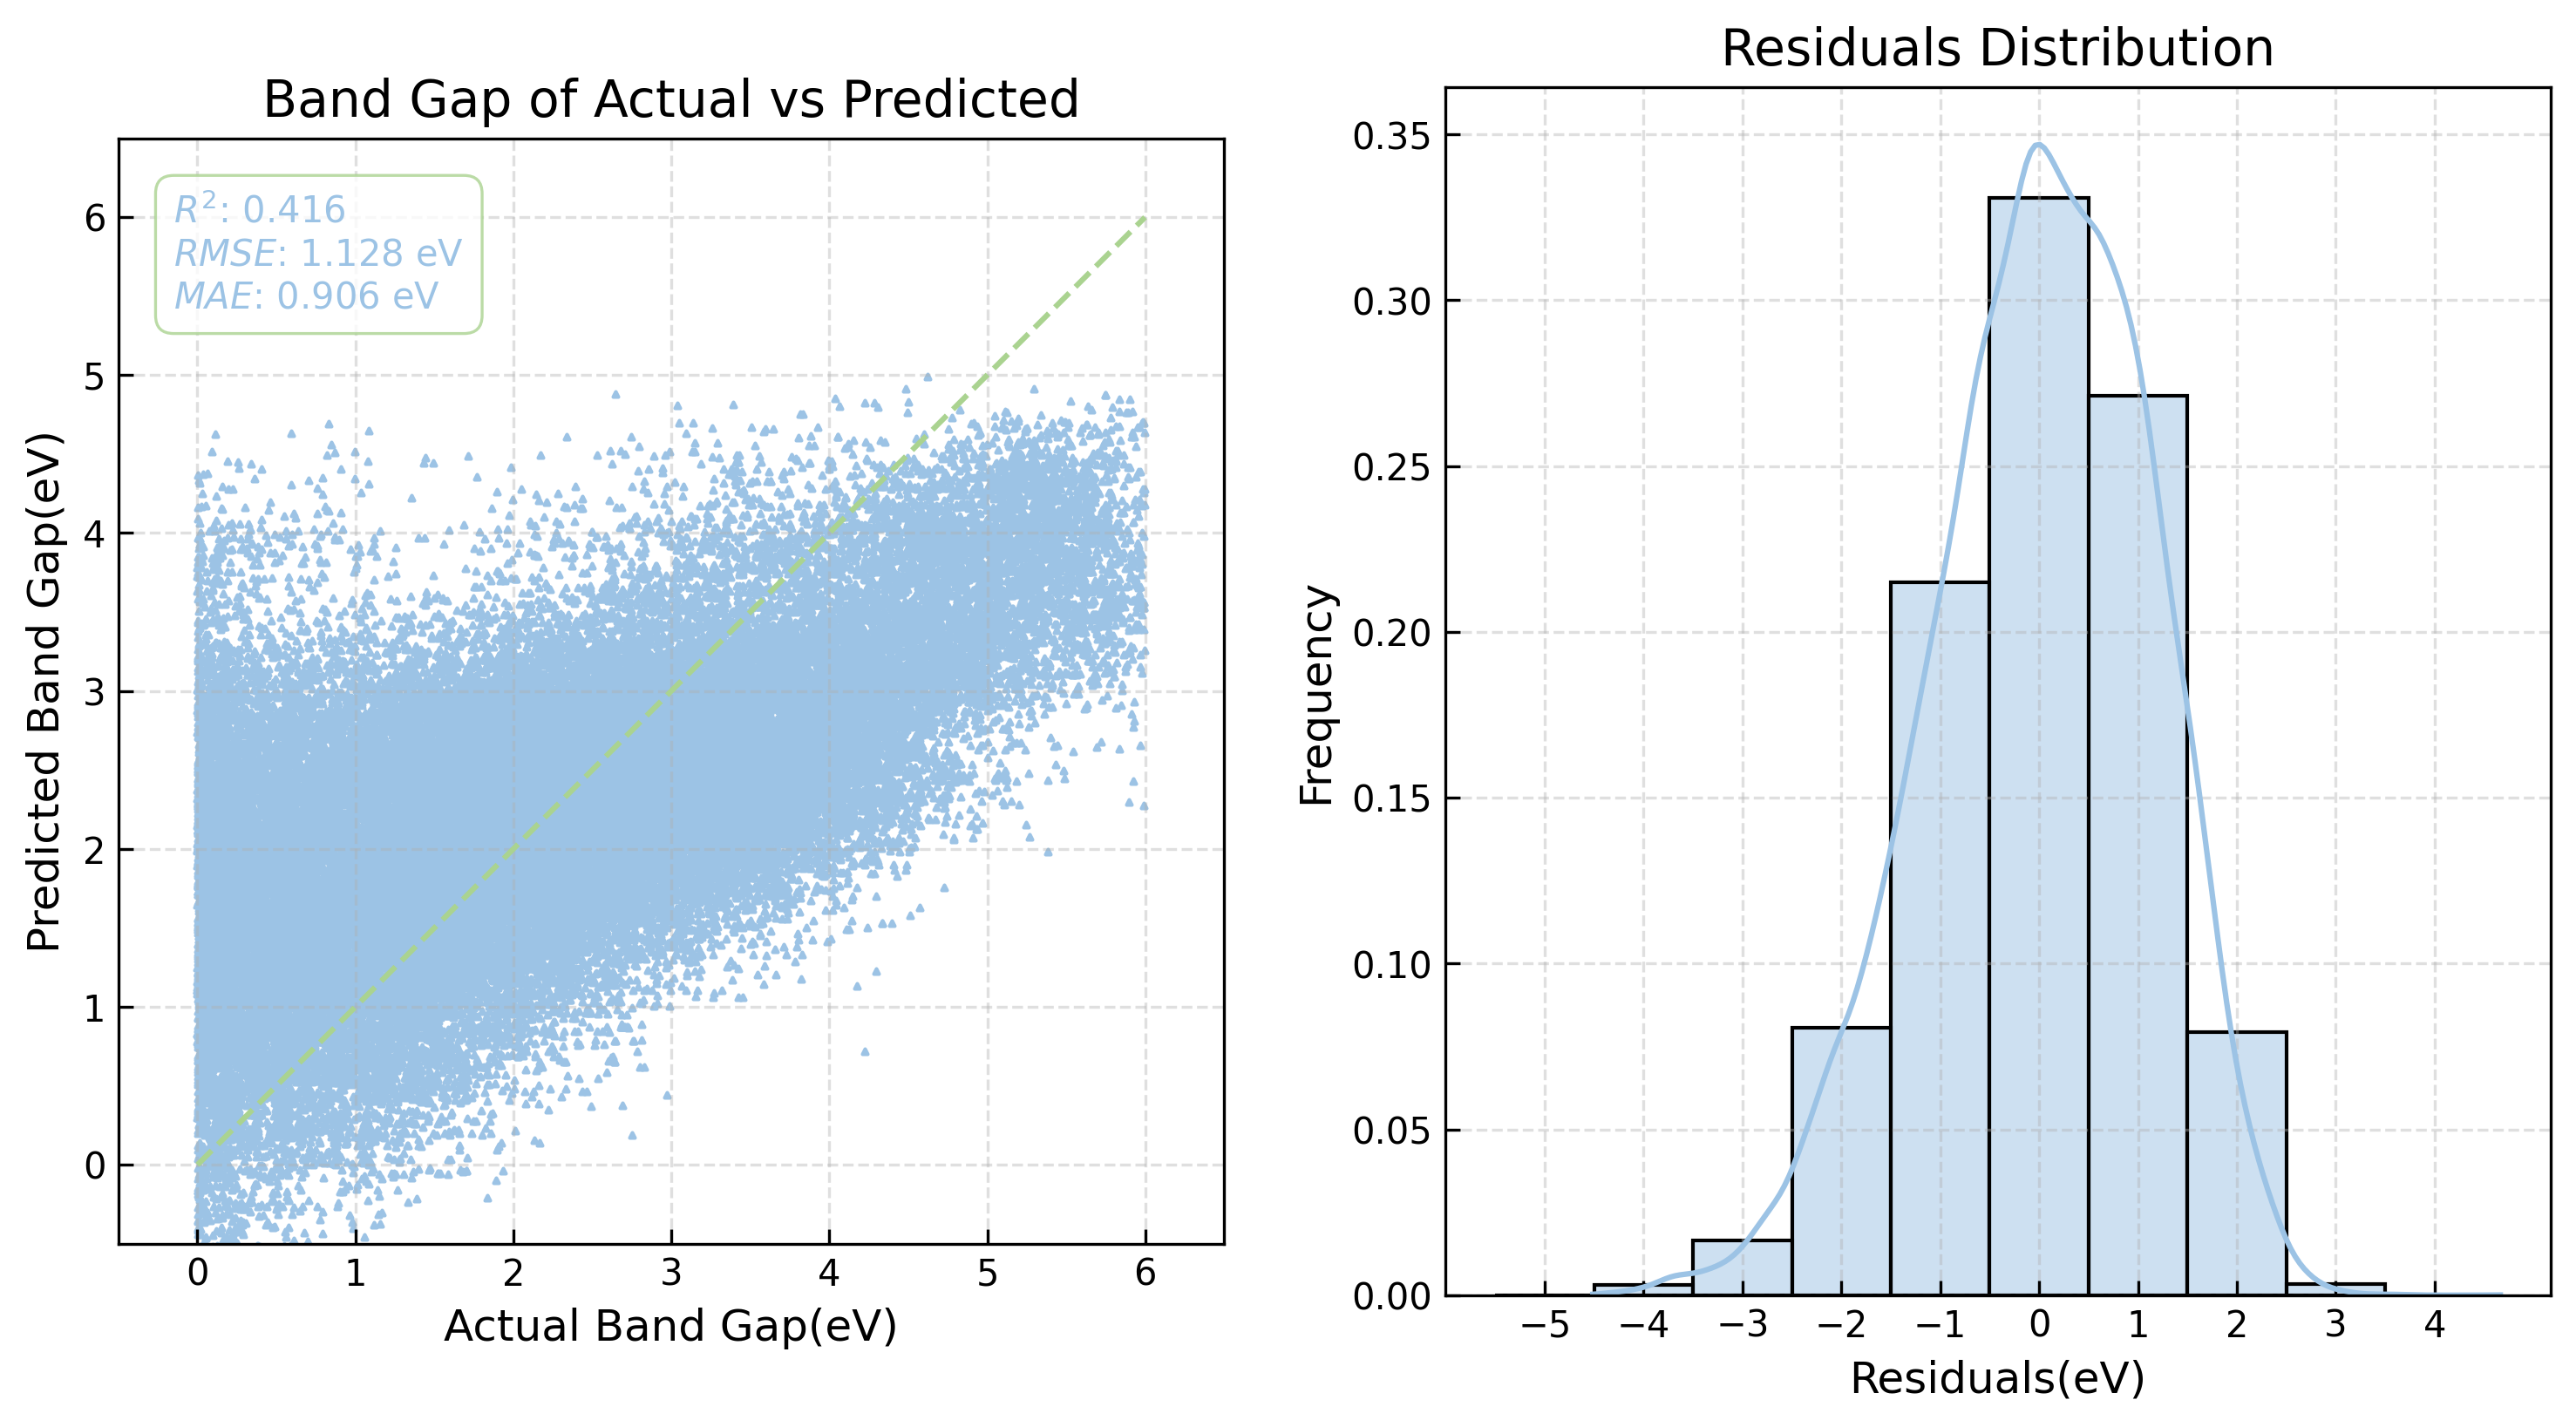


Model Evaluation Results:
Test set: R²: 0.4165 RMSE: 1.1280 MAE: 0.9061
[Test DFT -> DFT] Evaluating DFT ElasticNet on DFT test set:


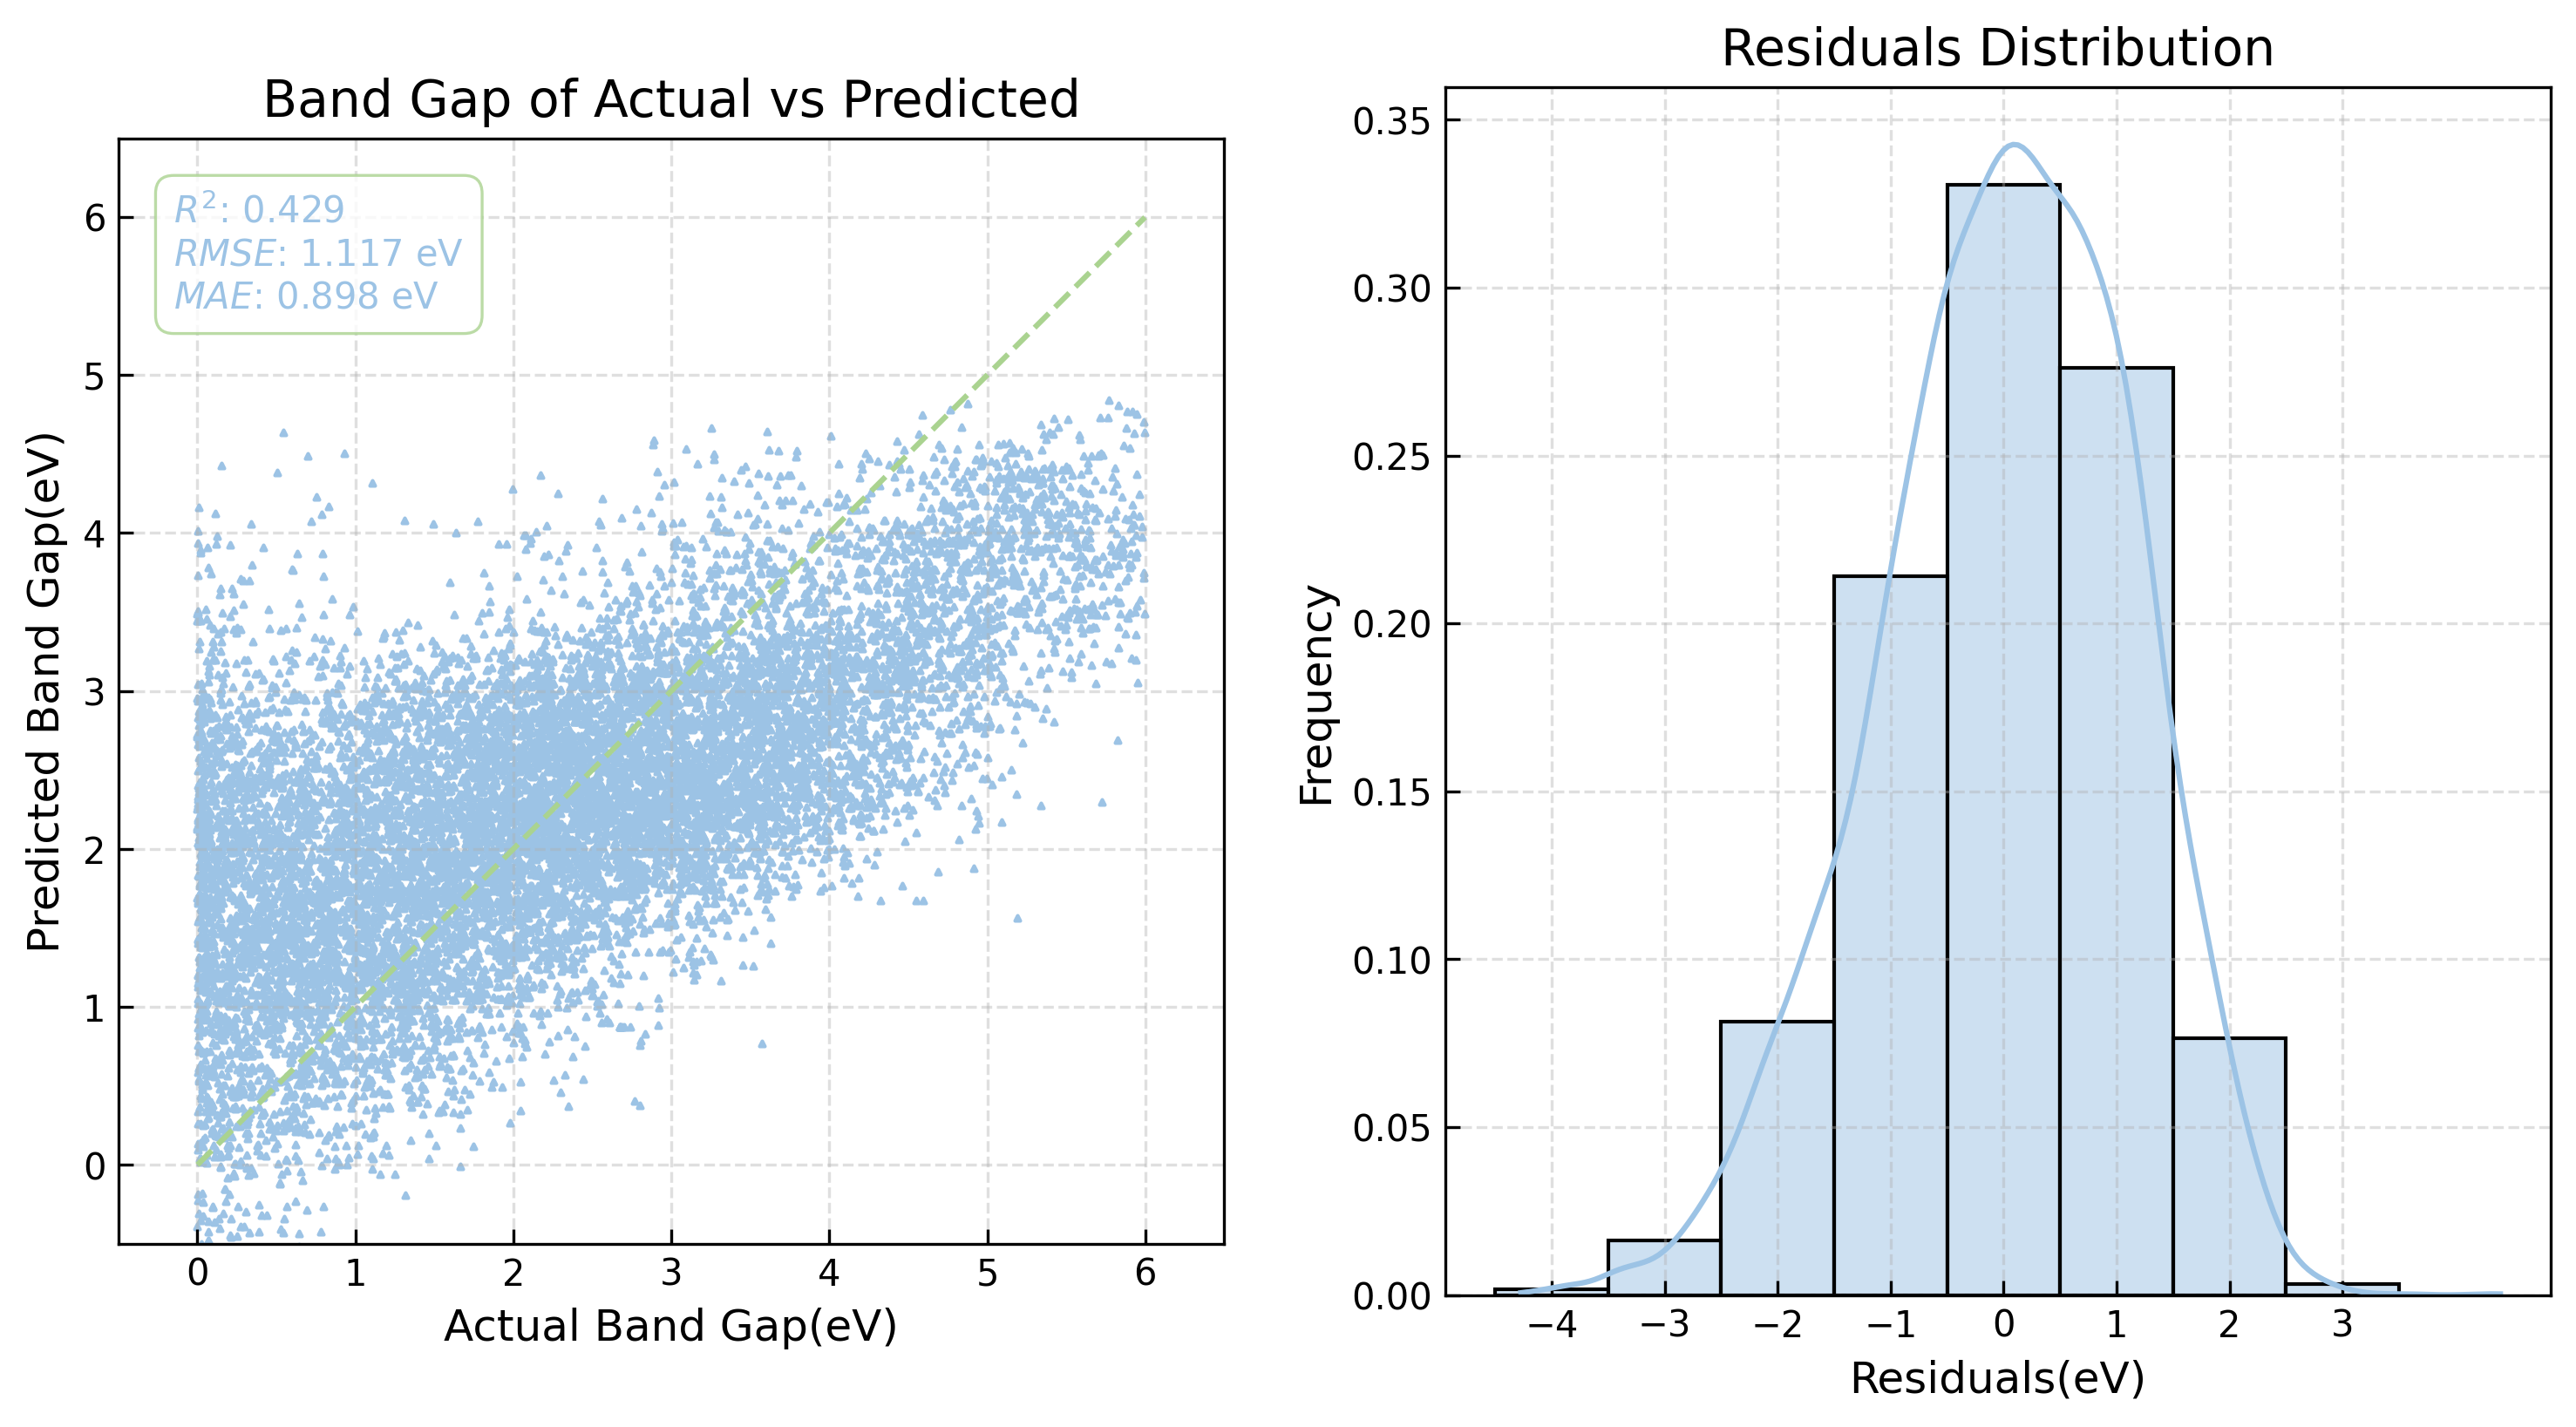


Model Evaluation Results:
Test set: R²: 0.4294 RMSE: 1.1165 MAE: 0.8978
[Test DFT -> EXP] Evaluating DFT ElasticNet on EXP test set:


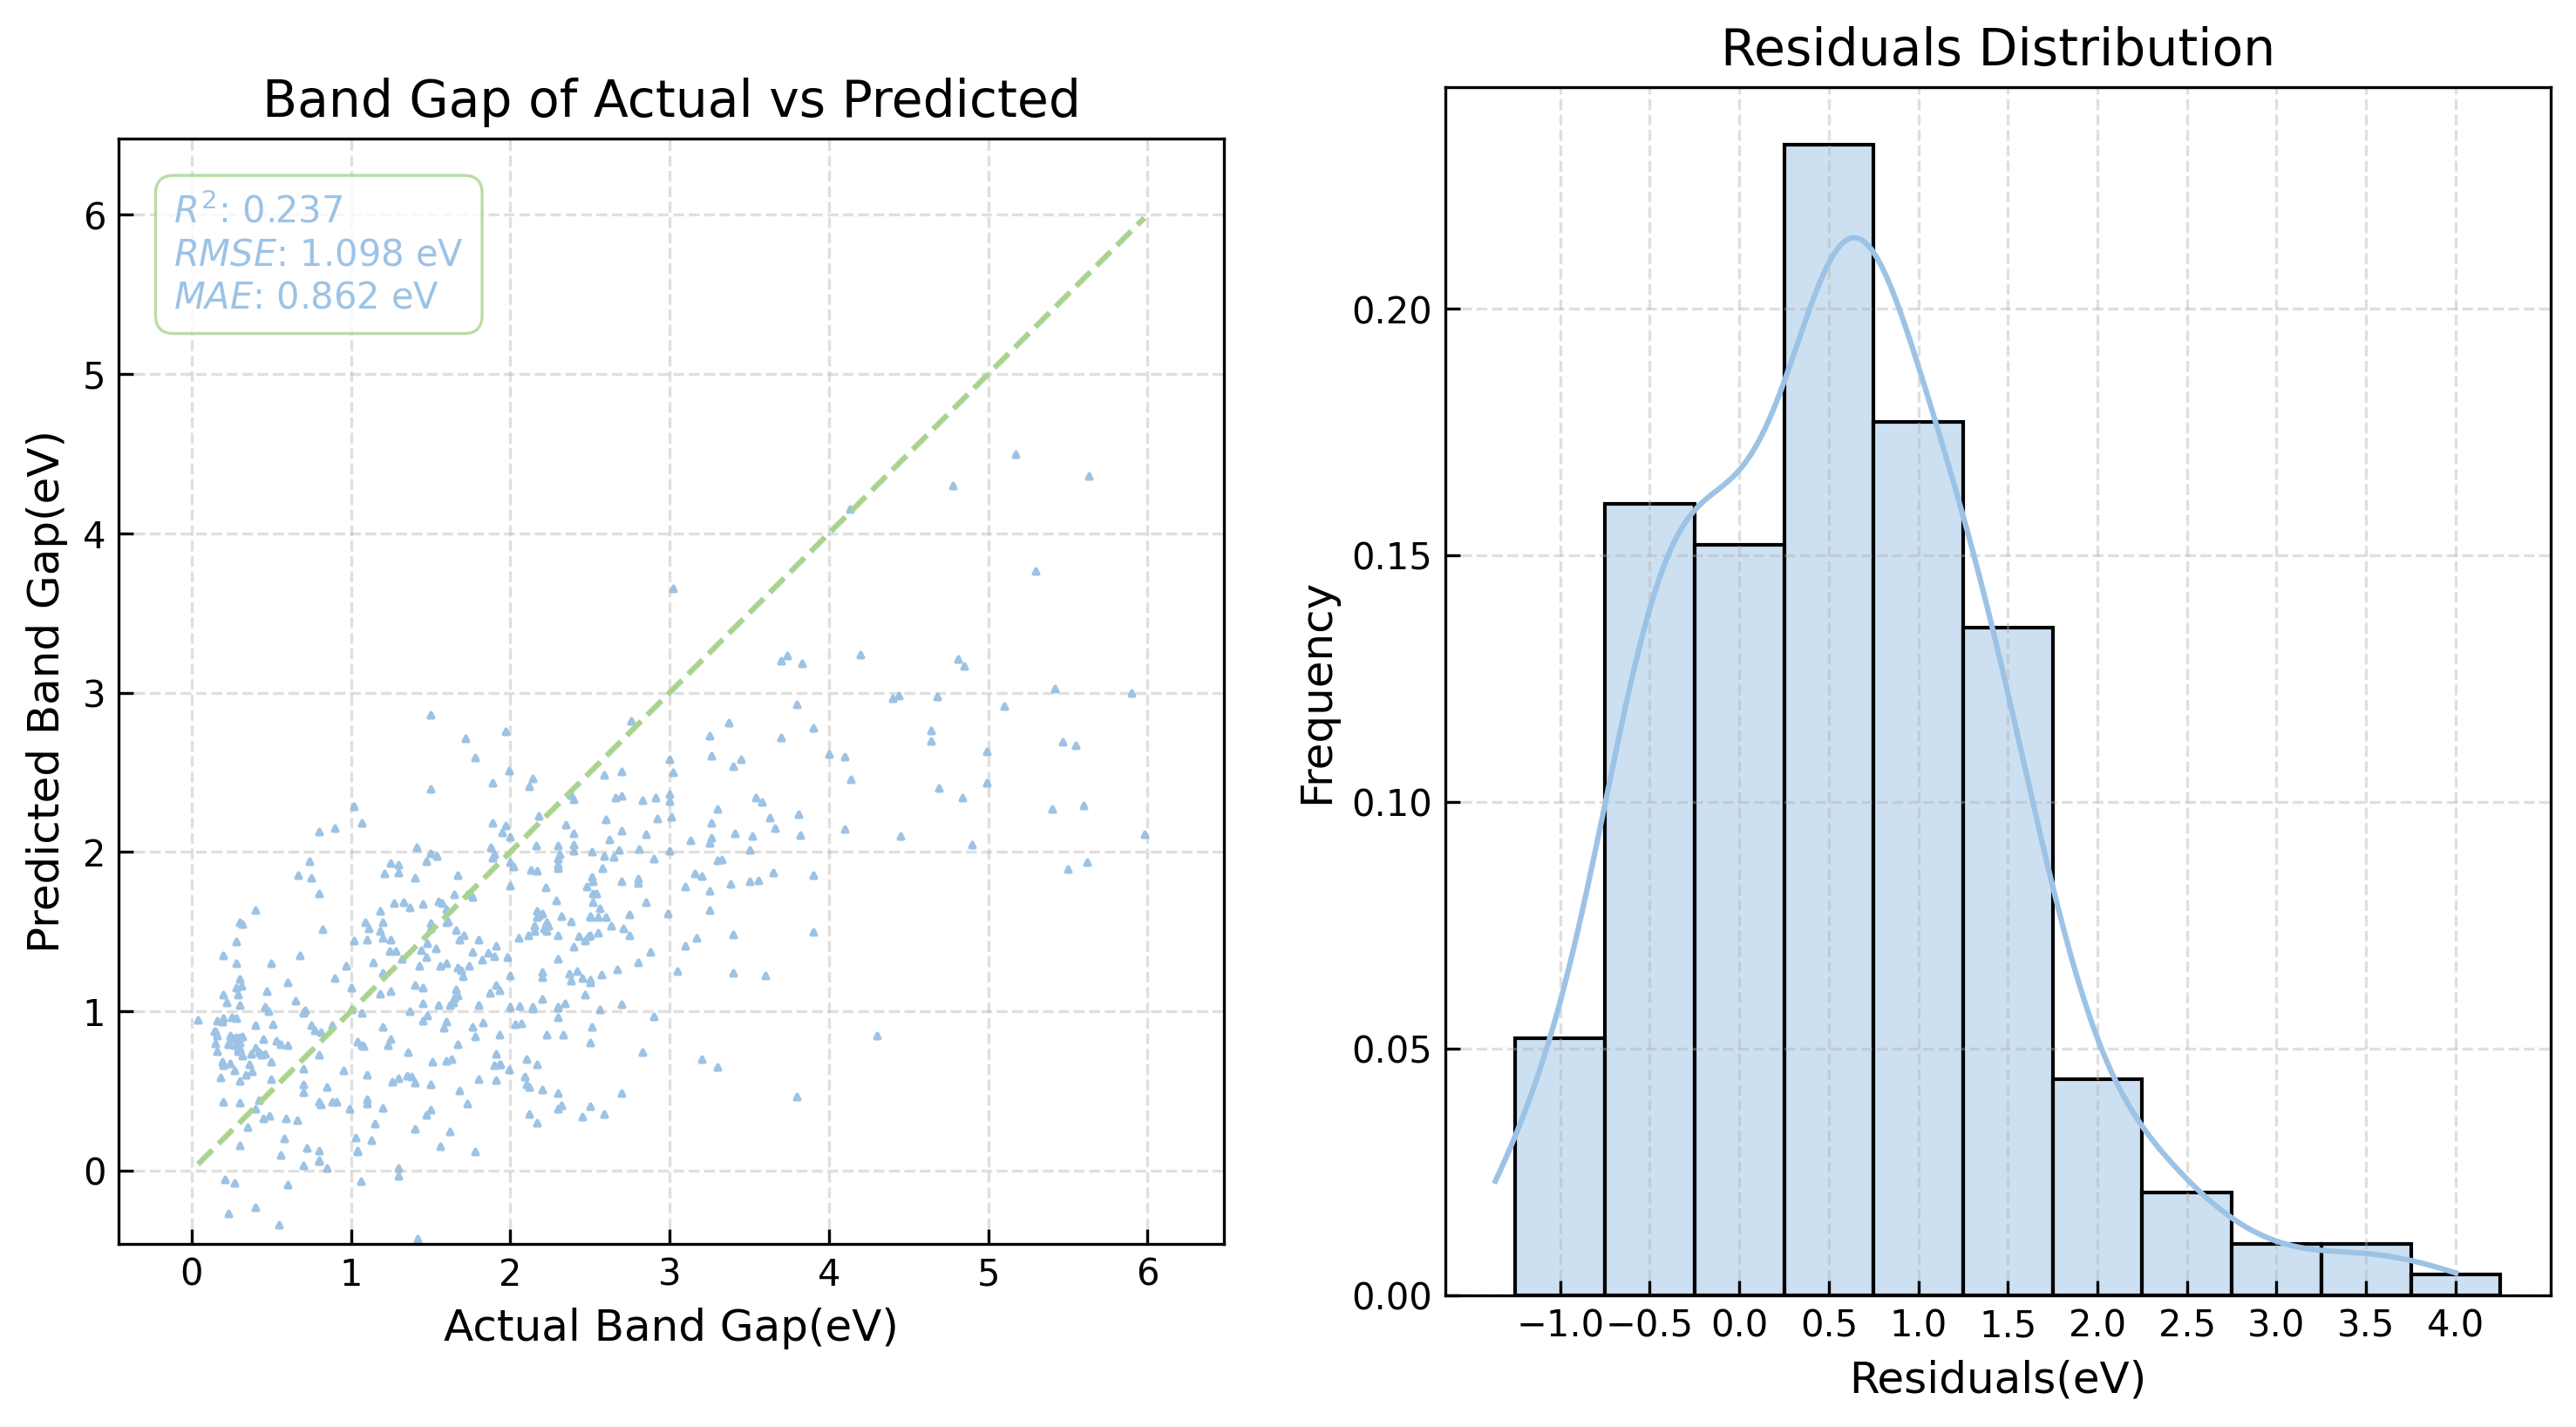


Model Evaluation Results:
Test set: R²: 0.2366 RMSE: 1.0980 MAE: 0.8615


In [14]:
# 
# Train the model with the best hyperparameters on the entire training set
model_name = 'ElasticNet'
elastic_net_best = ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=10000, random_state=RANDOM_SEED)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {model_name}] Training {model_name} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(elastic_net_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {model_name} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {model_name} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {model_name} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [15]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,ElasticNet,Train,dft,dft,0.416466,1.127998,0.906095
1,ElasticNet,Test,dft,dft,0.429443,1.116509,0.897839
2,ElasticNet,Test,dft,exp,0.236563,1.098023,0.861543


### EXP Model

In [24]:
# using grid search to find the best hyperparameters for the dft model
print("['EXP ElasticNet'] HP optimazation begin...")
# create a pipeline with standard scaler and ElasticNet
en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=10000, random_state=RANDOM_SEED))
])
# define the parameter grid for ElasticNet
param_grid = {
    'en__alpha': list(np.arange(0.05, 1.05, 0.05)) + [1.5, 2, 2.5, 3],
    'en__l1_ratio': np.arange(0.05, 1.05, 0.05)
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=en_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=1,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

['EXP ElasticNet'] HP optimazation begin...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('en',
                                        ElasticNet(max_iter=10000,
                                                   random_state=42))]),
             n_jobs=-1,
             param_grid={'en__alpha': [np.float64(0.05), np.float64(0.1),
                                       np.float64(0.15000000000000002),
                                       np.float64(0.2), np.float64(0.25),
                                       np.float64(0.3),
                                       np.float64(0.35000000000000003),...
                                       np.float64(0.7500000000000001),
                                       np.float64(0.8),
                                       np.float64(0.8500000000000001),
                                       np.float64(0.9000000000000001),
                                       np.float64(0.9500000000000001),
                                       np.float64(1.0), 1.5, 2, 2.5, 3],
                         'en__l1_ratio': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [25]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_en__alpha', 'param_en__l1_ratio', 
                               'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'en__alpha': np.float64(0.1), 'en__l1_ratio': np.float64(0.7000000000000001)}
Best Cross-Validation RMSE: 0.8043


,rank_test_score,param_en__alpha,param_en__l1_ratio,train_rmse,test_rmse
33,1,0.10,0.70,0.791672,0.804317
48,2,0.15,0.45,0.793577,0.805947
34,3,0.10,0.75,0.796380,0.808800
66,4,0.20,0.35,0.799272,0.811001
35,5,0.10,0.80,0.800512,0.812269


### Overfitting check

####################################################################################################
[EXP - ElasticNet] Training ElasticNet on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating EXP ElasticNet on EXP train set:


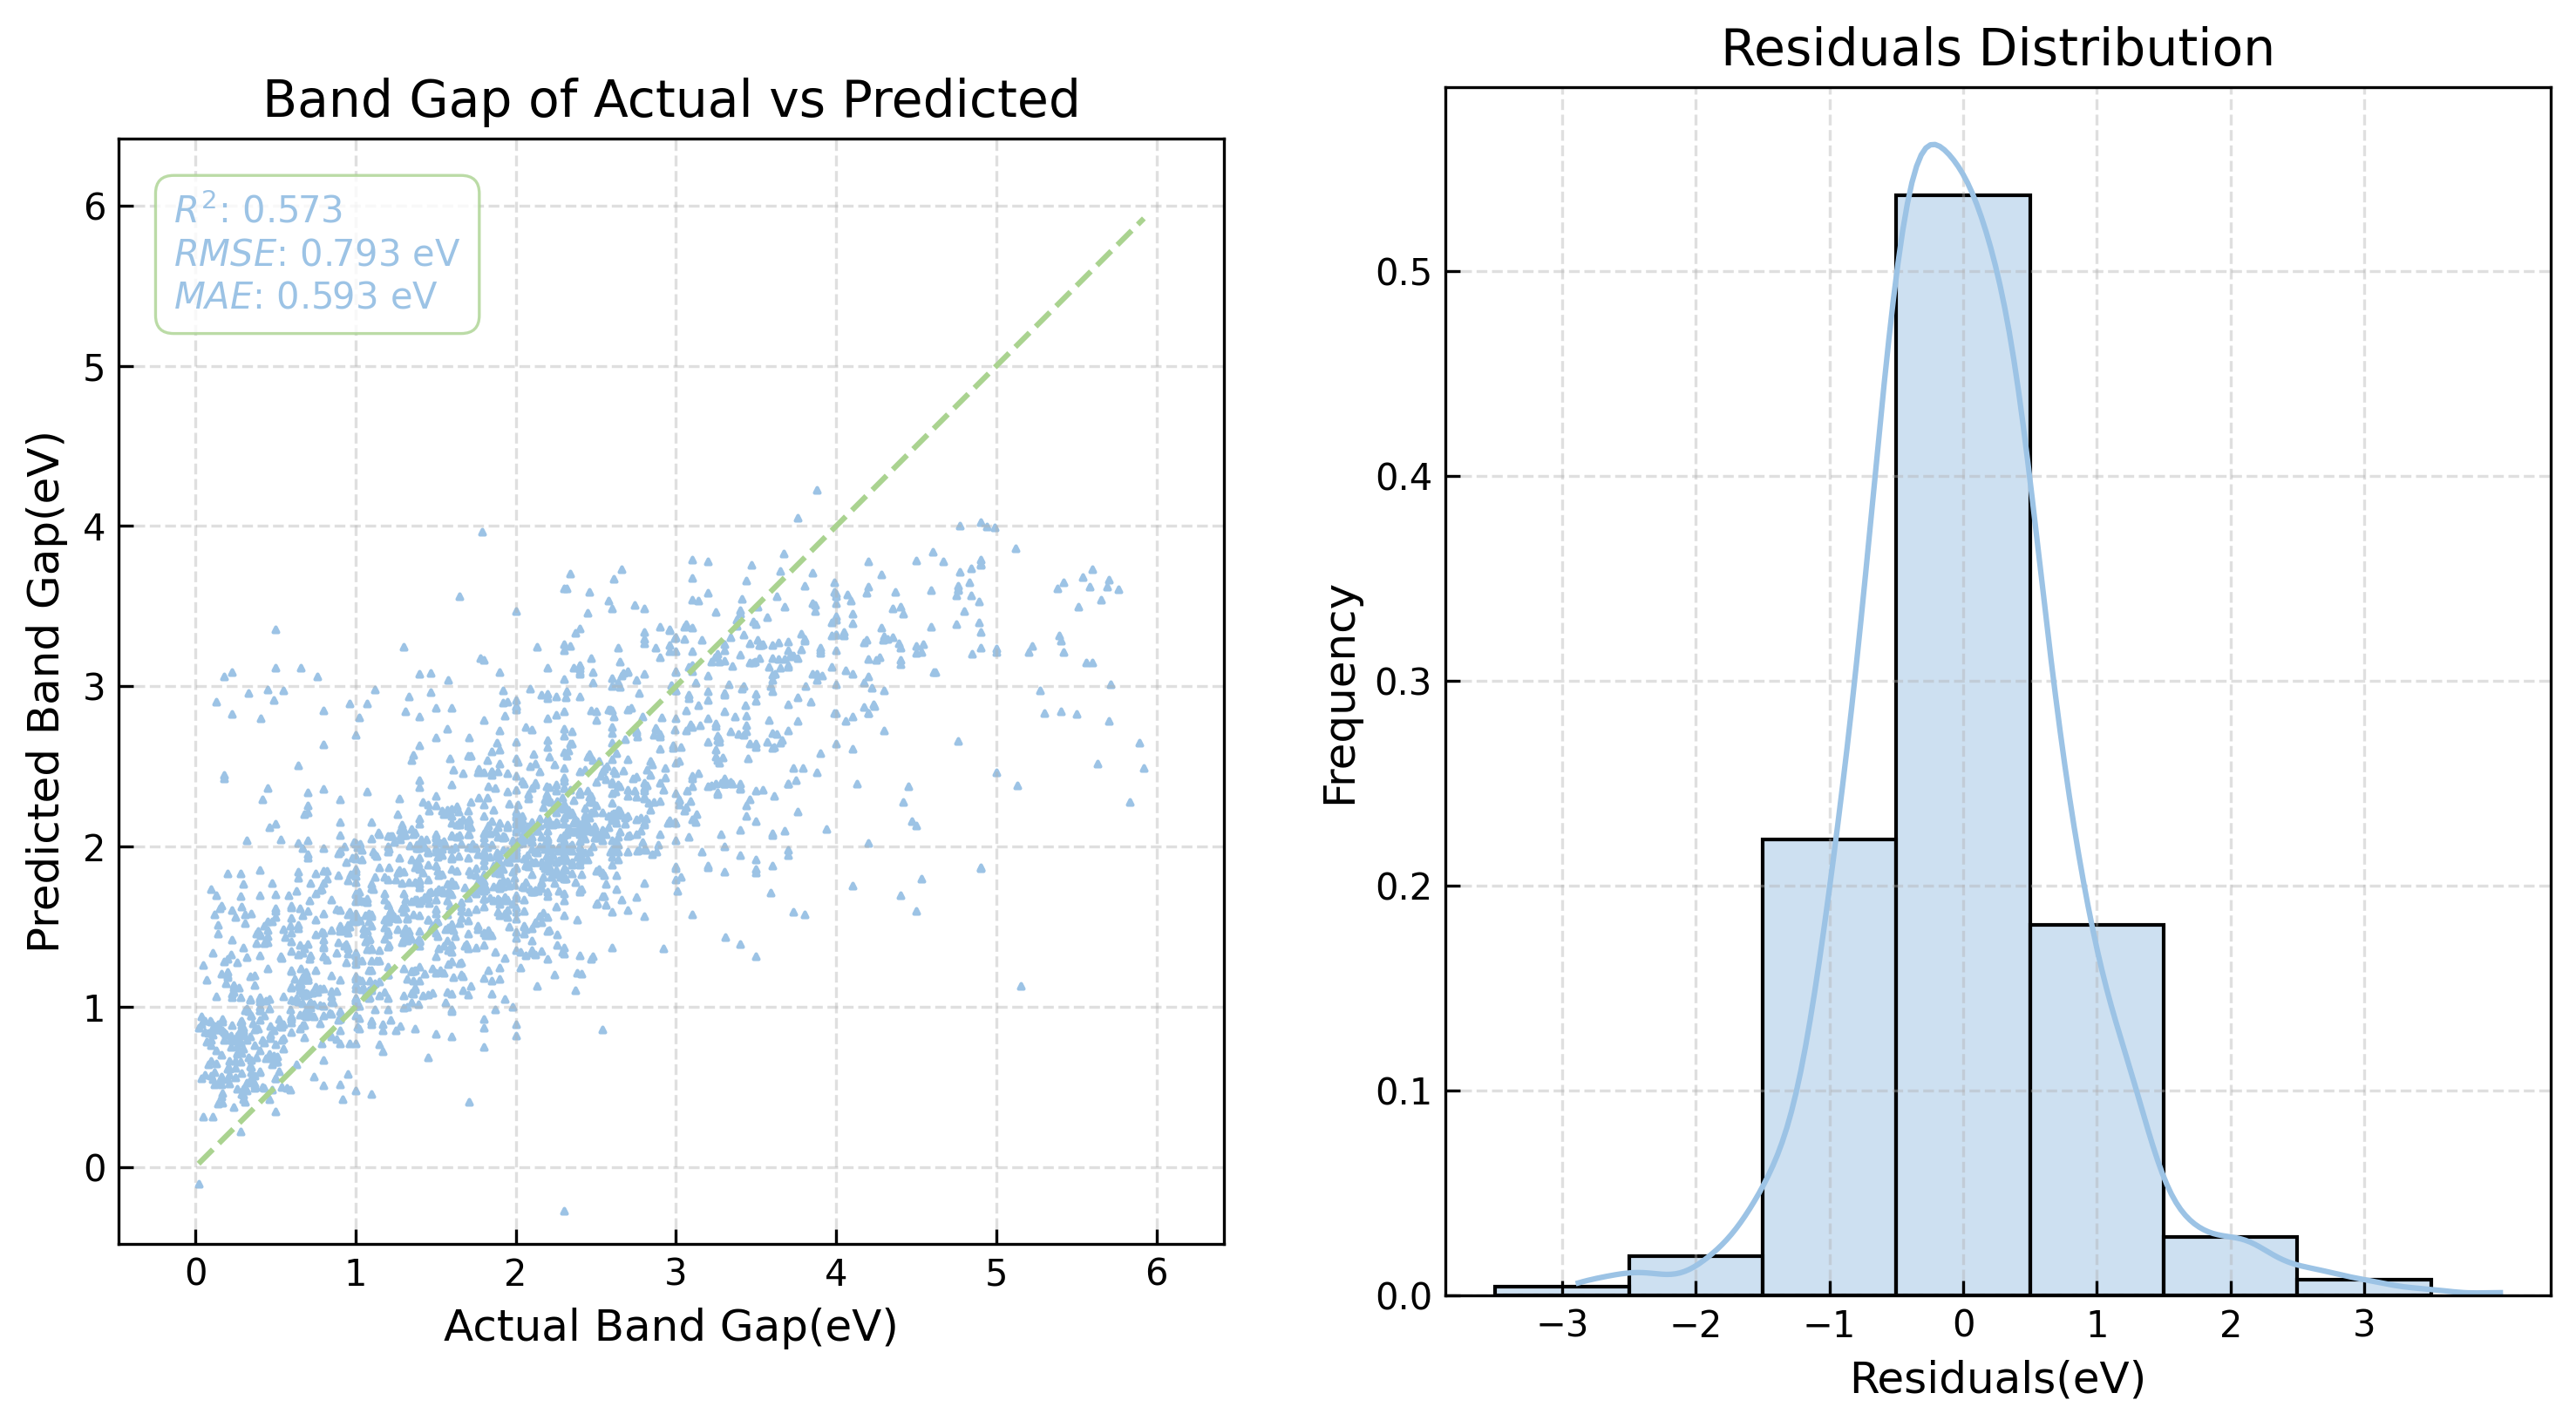


Model Evaluation Results:
Test set: R²: 0.5729 RMSE: 0.7930 MAE: 0.5927
[Test EXP -> EXP] Evaluating EXP ElasticNet on EXP test set:


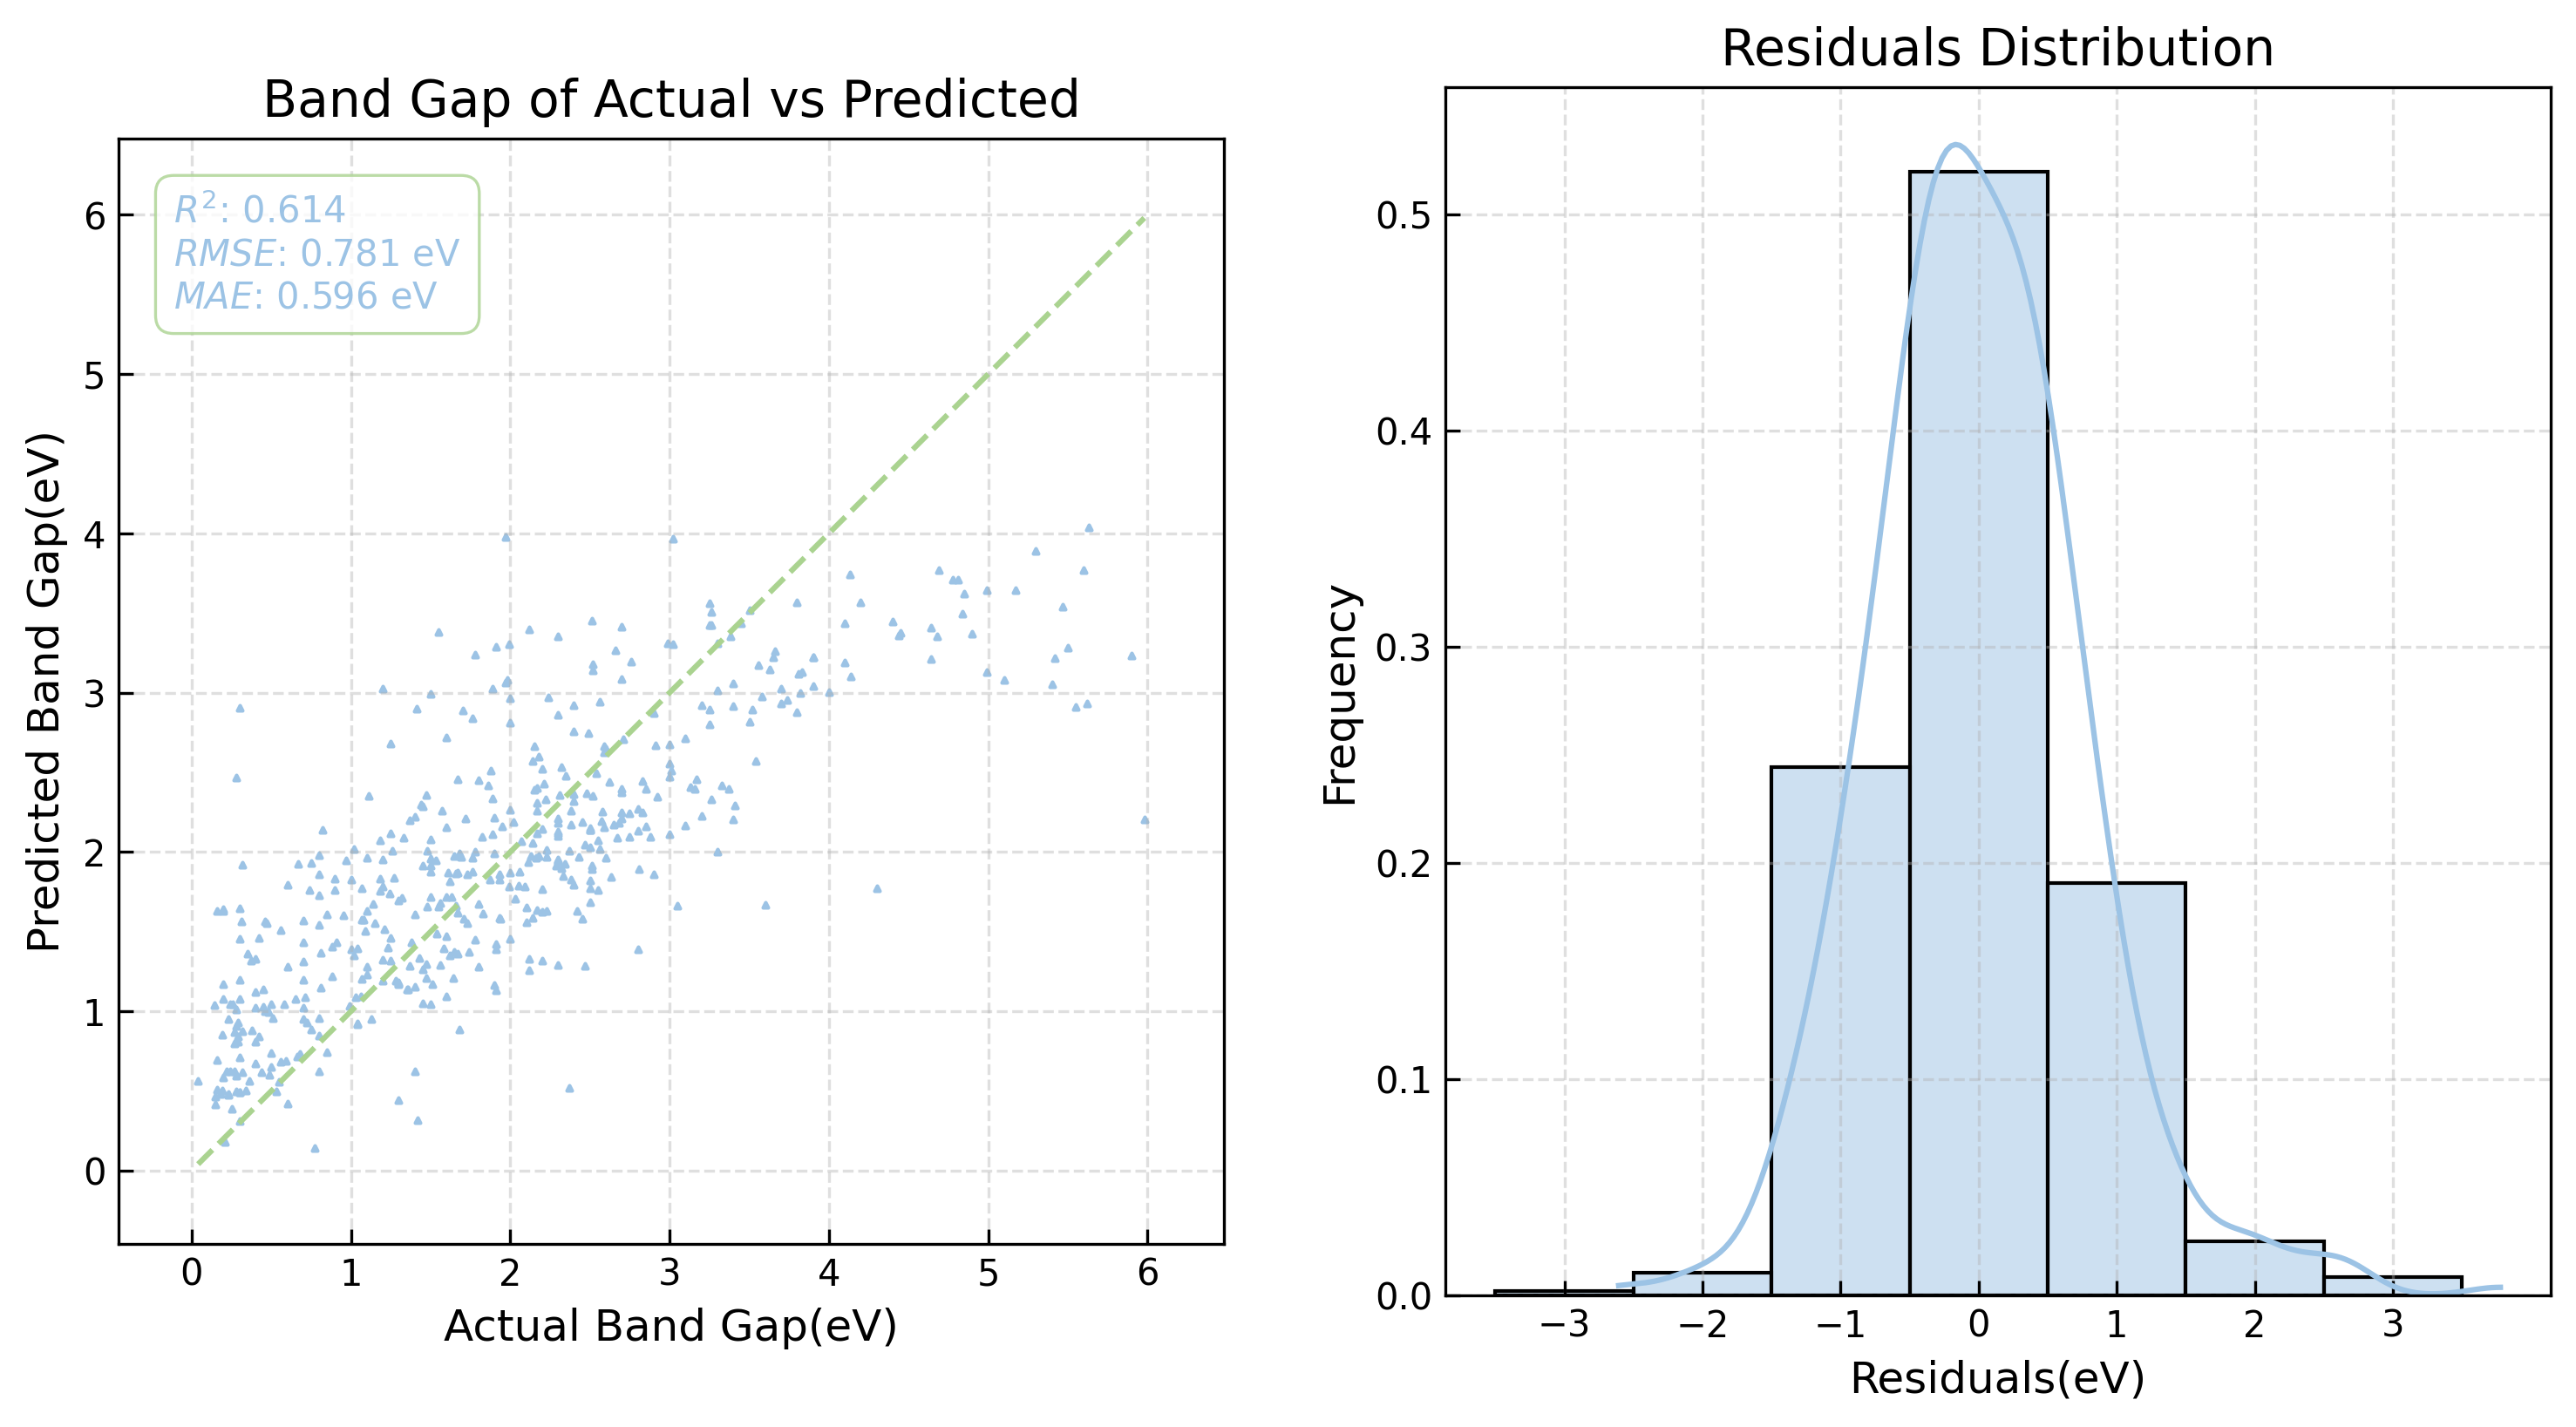


Model Evaluation Results:
Test set: R²: 0.6136 RMSE: 0.7811 MAE: 0.5959
[Test EXP -> DFT] Evaluating EXP ElasticNet on DFT test set:


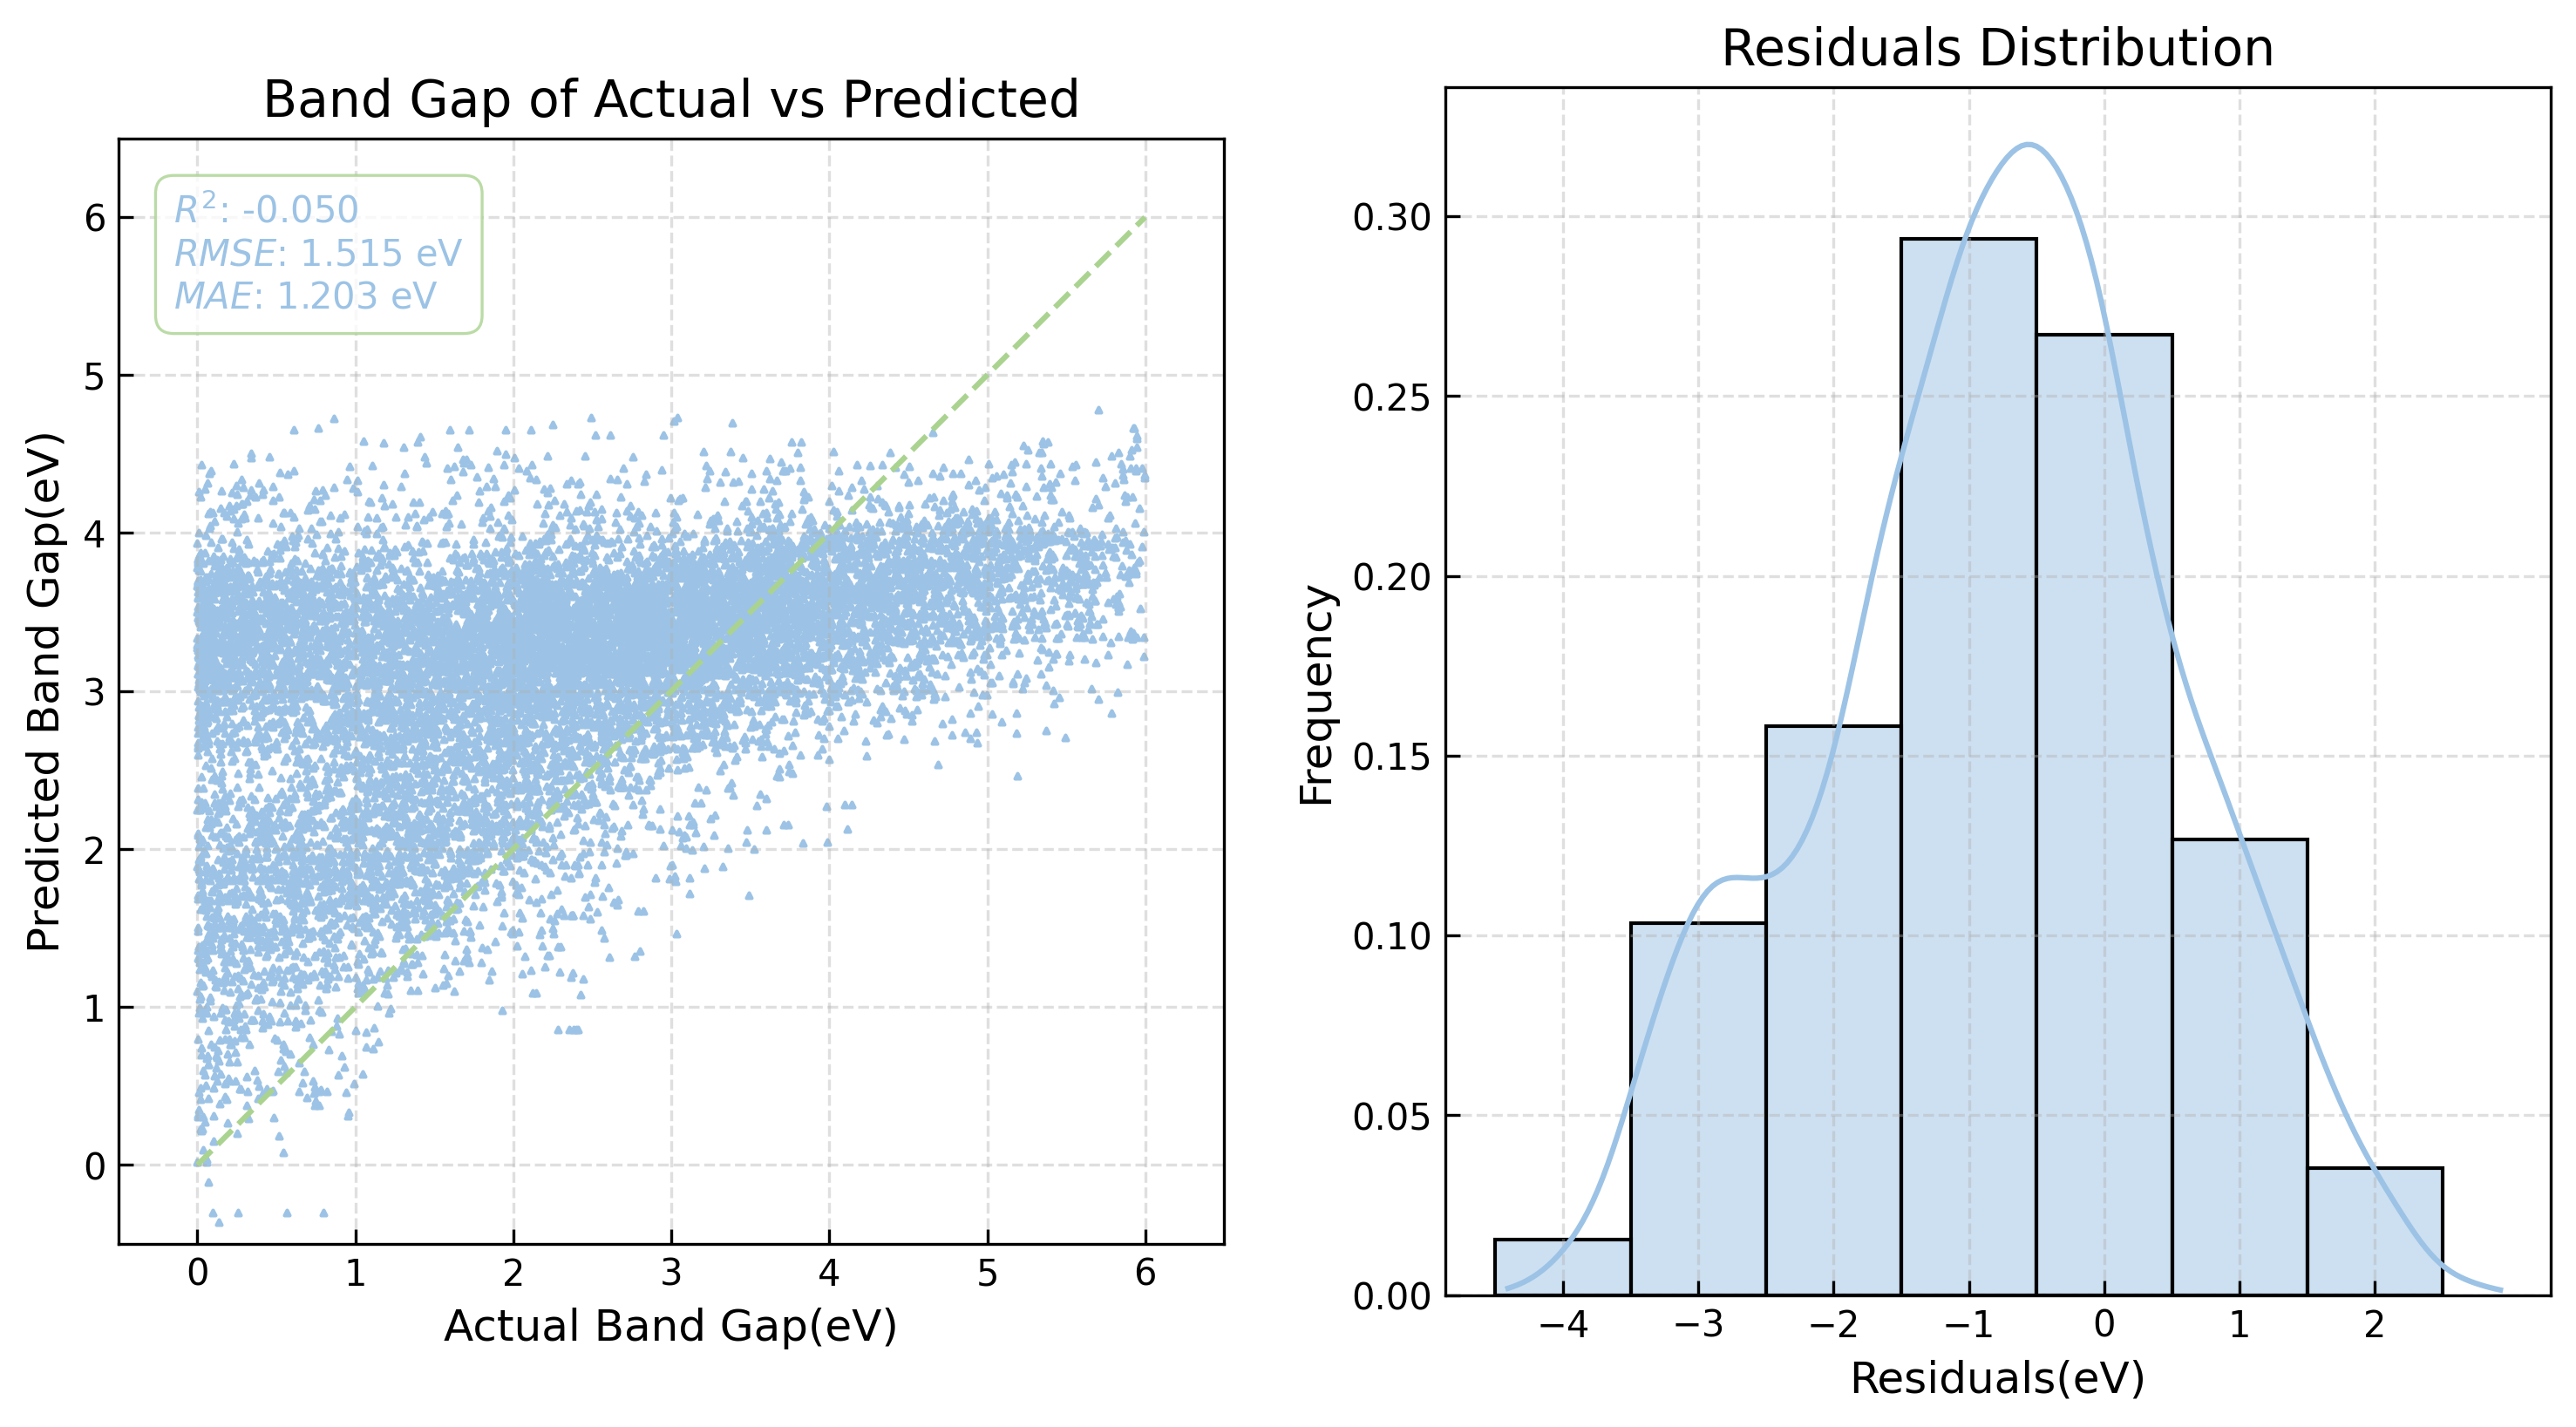


Model Evaluation Results:
Test set: R²: -0.0499 RMSE: 1.5146 MAE: 1.2034


In [18]:
# 
# Train the model with the best hyperparameters on the entire training set
model_name = 'ElasticNet'
elastic_net_best = ElasticNet(alpha=0.1, l1_ratio=0.7, max_iter=10000, random_state=RANDOM_SEED)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {model_name}] Training {model_name} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(elastic_net_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {model_name} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {model_name} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {model_name} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [19]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,ElasticNet,Train,exp,exp,0.572873,0.792978,0.592700
1,ElasticNet,Test,exp,exp,0.613636,0.781130,0.595852
2,ElasticNet,Test,exp,dft,-0.049937,1.514587,1.203403
